# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build a NLP molde to make reading medical abstracts easier.  
The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071  
And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3e52a971-3e4c-f307-f0b1-1d1cc481cfd4)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.  
We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all the filenames in the target directory
import os
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data
Now we've got some text data, it's time to become one with it.  
And one of the ways to become one with the data is to...  
> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename,"r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...  
How I think our data would be best represented.  
```
[{'line_number':0 ,
    'target' : "BACKGROUND",
    'text' : 'Yet , empirical evidence for individual ( trait ) differences in emotional eating and cognitive mechanisms that contribute to eating during sad mood remain equivocal .\n',
    'total_lines' : }]
```
Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith("###"):
      abtract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them in the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines+=line
  
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 726 ms, sys: 116 ms, total: 841 ms
Wall time: 1.19 s


Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


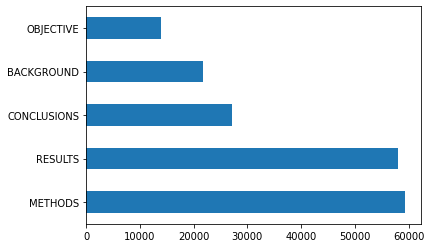

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts().plot(kind="barh");

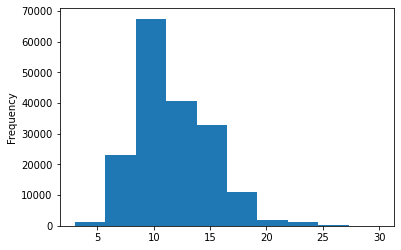

In [ ]:
# Check length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

## Making numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

### Label encode labels

In [ ]:
# Extract labels ("target columns") and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.  
And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf",TfidfVectorizer()),
                    ("clf",MultinomialNB())
])

# Fit the pipeline to training data
model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation data
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-13 07:11:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-13 07:11:31 (38.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate results
baseline_results = calculate_results(val_labels_encoded,baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

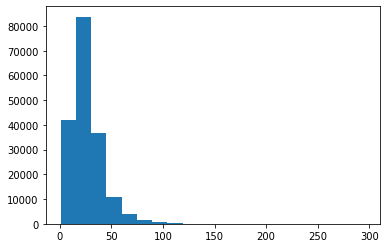

In [ ]:
# What's the ditribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [ ]:
# How long of a sentence length covers 95% of sentences?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
# Maximum length
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [ ]:
# How many words are in our vocab? 
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
significant improvement in the scores of the roland & morris questionnaire was observed in both groups .

Length of text: 104

Vectorized text: [[   37   194     5     2   119     4     2 10990  9640   325    10   148
      5    54    24     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),output_dim=128,mask_zero=True,name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after emedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 significant improvement in the scores of the roland & morris questionnaire was observed in both groups .

Sentence after vectorization (before embedding):
 [[   37   194     5     2   119     4     2 10990  9640   325    10   148
      5    54    24     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after emedding:
 [[[-0.0287546  -0.03601485 -0.0135499  ... -0.02250745  0.01638636
    0.02583662]
  [ 0.04671047 -0.00772351 -0.02476339 ... -0.01911372 -0.00074505
    0.00551714]
  [ 0.01172435  0.02093604 -0.04055042 ... -0.0379711   0.01212115
    0.04012424]
  ...
  [ 0.04118538  0.02066542  0.03565593 ... -0.01011174 -0.01980219
   -0.00446198]
  [ 0.04118538  0.02066542  0.03565593 ... -0.01011174 -0.01980219
   -0.00446198]
  [ 0.04118538  0.02066

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the Tensorflow `tf.data` API.

In [ ]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
# Take the TensorSliceDatasets and turn them into prefecthed datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D Conv model to process sequences
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Get the summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.9198 - accuracy: 0.6366 - val_loss: 0.6821 - val_accuracy: 0.7443
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6541 - accuracy: 0.7576 - val_loss: 0.6248 - val_accuracy: 0.7726
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6150 - accuracy: 0.7742 - val_loss: 0.5964 - val_accuracy: 0.7862


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5978 - accuracy: 0.7870


[0.597769558429718, 0.787038266658783]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

(array([[4.41503048e-01, 1.47255942e-01, 7.93214813e-02, 3.03674191e-01,
         2.82453280e-02],
        [4.60359842e-01, 2.39316285e-01, 1.36031052e-02, 2.78577626e-01,
         8.14310554e-03],
        [1.44000500e-01, 6.27144007e-03, 1.09211390e-03, 8.48600686e-01,
         3.52491552e-05],
        ...,
        [3.20522781e-06, 4.10798093e-04, 4.46883321e-04, 1.87227272e-06,
         9.99137223e-01],
        [7.04520717e-02, 4.45390910e-01, 1.12844825e-01, 6.92560896e-02,
         3.02056134e-01],
        [1.31162569e-01, 7.32514381e-01, 4.31559086e-02, 3.93860452e-02,
         5.37810586e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.70382629418773,
 'f1': 0.7846570192037126,
 'precision': 0.7839713327079822,
 'recall': 0.7870382629418774}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained feature extraction  
Now lets use the pretrained word embeddings from Tensorflow Hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4  
The paper originally used GloVe embeddings, however, we're going to stick with the later created USE.

In [ ]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 compared with the instructor-led group , there was more peer assistance , feedback , collaboration , and hands-on and active learning observed in the sl group .
Sentence after embedding:
[-0.02644051  0.00737029 -0.00249277 -0.07461103 -0.0628912   0.01585762
  0.00011118 -0.06604271 -0.06058475  0.05943435 -0.00603759  0.06145729
  0.06378393 -0.00843952  0.03008921  0.03507518 -0.01776699 -0.00491579
  0.04223558 -0.05682407  0.07550554  0.01523279 -0.07441881 -0.02301049
 -0.00739074  0.05292457 -0.06428138  0.06301091  0.03630779 -0.04926185]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings Tensorflow Hub

In [ ]:
# Define feature extraction model
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
# Note: you could add more layers here
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,outputs=outputs,name="model_2_USE_feature_extraction")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get the summary
model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9157 - accuracy: 0.6497 - val_loss: 0.7954 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7685 - accuracy: 0.7021 - val_loss: 0.7540 - val_accuracy: 0.7068
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7524 - accuracy: 0.7115 - val_loss: 0.7403 - val_accuracy: 0.7151


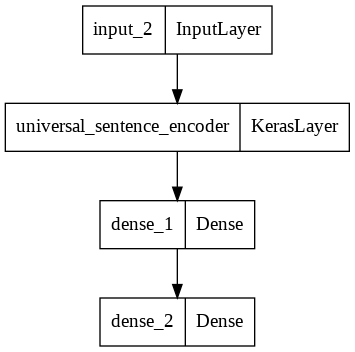

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_2)

In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7419 - accuracy: 0.7144


[0.7418560981750488, 0.7143850326538086]

In [ ]:
# Make predictions on the valid dataset
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

array([[3.9725918e-01, 3.7728271e-01, 2.4114433e-03, 2.1425983e-01,
        8.7868990e-03],
       [3.4258872e-01, 4.8631048e-01, 3.8675591e-03, 1.6344112e-01,
        3.7921639e-03],
       [2.2946623e-01, 1.6053157e-01, 1.8300144e-02, 5.5141807e-01,
        4.0284090e-02],
       [1.3835074e-02, 4.6614636e-02, 8.2832879e-01, 8.7802103e-03,
        1.0244138e-01],
       [3.0171566e-02, 2.2216170e-01, 2.4496047e-01, 1.5598073e-02,
        4.8710823e-01],
       [8.4335811e-04, 2.0386148e-03, 6.7329335e-01, 1.1544066e-04,
        3.2370925e-01],
       [2.0495181e-03, 3.1122889e-03, 6.5670639e-01, 1.1969866e-03,
        3.3693478e-01],
       [4.1769231e-03, 1.8180279e-02, 4.5243645e-01, 1.1103288e-03,
        5.2409601e-01],
       [7.5910898e-04, 6.2367343e-03, 1.9658493e-02, 1.2477847e-03,
        9.7209787e-01],
       [1.3540316e-01, 6.9805223e-01, 2.2993064e-02, 7.6040640e-02,
        6.7510940e-02]], dtype=float32)

In [ ]:
# Convert the prediction probabilities found with feature extraction model
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings
model_2_results = calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 71.43850125777837,
 'f1': 0.7115836766641098,
 'precision': 0.7148254177110834,
 'recall': 0.7143850125777836}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.  
Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'c o m p a r e d   w i t h   t h e   i n s t r u c t o r - l e d   g r o u p   ,   t h e r e   w a s   m o r e   p e e r   a s s i s t a n c e   ,   f e e d b a c k   ,   c o l l a b o r a t i o n   ,   a n d   h a n d s - o n   a n d   a c t i v e   l e a r n i n g   o b s e r v e d   i n   t h e   s l   g r o u p   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Average character length
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(chars_lens)
mean_char_lens

149.3662574983337

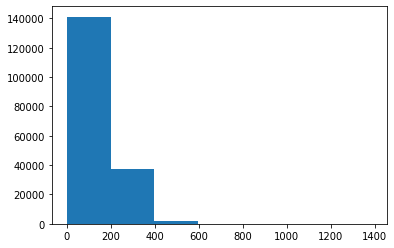

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(chars_lens,bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(chars_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,output_sequence_length=output_seq_char_len,standardize="lower_and_strip_punctuation",name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 i n   a d d i t i o n   ,   t h e   @ - y e a r   s u r v i v a l   r a t e   w a s   c a l c u l a t e d   .
Length of random_train_chars: 46

Vectorized chars:
 [[ 4  6  5 10 10  4  3  4  7  6  3 13  2 19  2  5  8  9 16  8 21  4 21  5
  12  8  5  3  2 20  5  9 11  5 12 11 16 12  5  3  2 10  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  

## Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 i n   a d d i t i o n   ,   t h e   @ - y e a r   s u r v i v a l   r a t e   w a s   c a l c u l a t e d   .

Embedded chars. (after vectorization and embedding):
 [[[-0.03932812  0.01055238 -0.01933837 ...  0.01081092 -0.04498572
    0.00695019]
  [ 0.0274532  -0.01153585  0.02802415 ... -0.02584541 -0.01264935
   -0.03722888]
  [-0.02852321  0.01881713  0.0385639  ...  0.04806137 -0.04302081
   -0.04073819]
  ...
  [-0.03398832 -0.03878353  0.00381967 ...  0.0482635  -0.03309361
   -0.01295637]
  [-0.03398832 -0.03878353  0.00381967 ...  0.0482635  -0.03309361
   -0.01295637]
  [-0.03398832 -0.03878353  0.00381967 ...  0.0482635  -0.03309361
   -0.01295637]]]
Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,),dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_conv1d_char_embeddings")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Get the summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

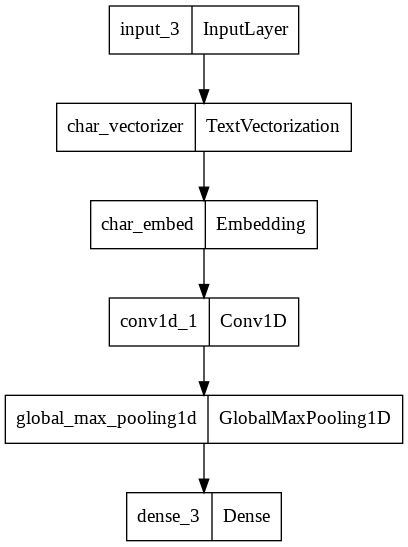

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_3)

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2627 - accuracy: 0.4889 - val_loss: 1.0459 - val_accuracy: 0.5941
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0058 - accuracy: 0.5976 - val_loss: 0.9396 - val_accuracy: 0.6316
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9177 - accuracy: 0.6393 - val_loss: 0.8691 - val_accuracy: 0.6735


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.20253527, 0.18647942, 0.17797548, 0.40112445, 0.03188537],
       [0.12692343, 0.73561585, 0.01202322, 0.09720618, 0.02823129],
       [0.11334297, 0.16929013, 0.19484621, 0.51043415, 0.01208653],
       ...,
       [0.01671089, 0.02905928, 0.10149804, 0.03230532, 0.82042646],
       [0.07970996, 0.17724779, 0.28524375, 0.05274029, 0.40505818],
       [0.46207437, 0.22705892, 0.22202301, 0.05969839, 0.02914524]],
      dtype=float32)

In [ ]:
# Convert predictions to labels
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Calculate the results
model_3_results = calculate_results(val_labels_encoded,model_3_preds)
model_3_results

{'accuracy': 66.03336422613532,
 'f1': 0.6497859863973063,
 'precision': 0.653181385139902,
 'recall': 0.6603336422613532}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid model)  

1. Create a token level embedding model (similar to `model_1`).
2. Create a character-level model (similar to `model_3` with a slight modification).
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`).
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the paper.  
5. Construct a model which takes tokens and character-level sequences as inputs and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

In [ ]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

In [ ]:
# 3. Concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,char_model.output])

In [ ]:
# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

In [ ]:
# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
# Get the summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

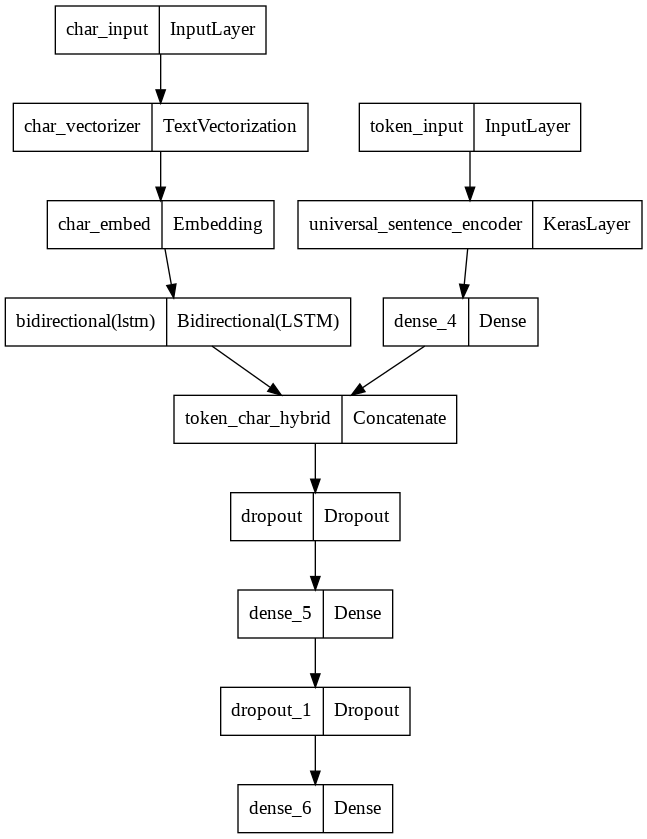

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine training chars and tokens into a train dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data

# Combine validation chars and tokens into a valid dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

# Prefetch and batch valid data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 47s 67ms/step - loss: 0.9859 - accuracy: 0.6114 - val_loss: 0.7781 - val_accuracy: 0.7035
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.8045 - accuracy: 0.6905 - val_loss: 0.7250 - val_accuracy: 0.7291
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7761 - accuracy: 0.7042 - val_loss: 0.6865 - val_accuracy: 0.7367


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.6933 - accuracy: 0.7375


[0.6933102011680603, 0.7375215291976929]

In [ ]:
# Make predictions using the token-char hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:10]

array([[4.1341794e-01, 3.4949216e-01, 4.9407524e-03, 2.2197638e-01,
        1.0172753e-02],
       [3.6446652e-01, 3.6004174e-01, 4.1432609e-03, 2.6839820e-01,
        2.9502830e-03],
       [2.1730252e-01, 7.6766737e-02, 2.8861448e-02, 6.5515304e-01,
        2.1916319e-02],
       [1.1202299e-02, 1.8246716e-02, 8.6963445e-01, 4.6964646e-03,
        9.6220031e-02],
       [2.0249816e-02, 1.2896743e-01, 5.2693129e-01, 8.4916735e-03,
        3.1535986e-01],
       [6.6349457e-04, 2.8801684e-03, 6.6351336e-01, 2.4303728e-04,
        3.3269989e-01],
       [1.8869940e-03, 1.1854058e-02, 5.9512228e-01, 8.2140416e-04,
        3.9031526e-01],
       [1.3327692e-03, 1.4183193e-02, 6.1781657e-01, 4.4831072e-04,
        3.6621922e-01],
       [6.8109308e-04, 1.0765904e-02, 4.5457073e-02, 4.2791470e-04,
        9.4266796e-01],
       [1.7440464e-01, 5.8488226e-01, 4.0244725e-02, 1.1258212e-01,
        8.7886289e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds= tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results
model_4_results = calculate_results(val_labels_encoded,model_4_preds)
model_4_results

{'accuracy': 73.75215146299485,
 'f1': 0.7348925840679101,
 'precision': 0.73715944406448,
 'recall': 0.7375215146299484}

## Model 5: Tranfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑**Note:** Any engineered features used to train a model need to be availabel at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

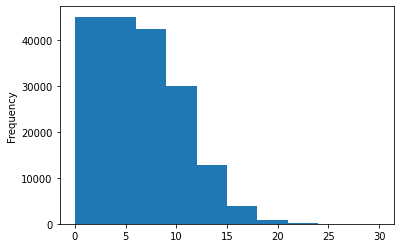

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot =  tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)


Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

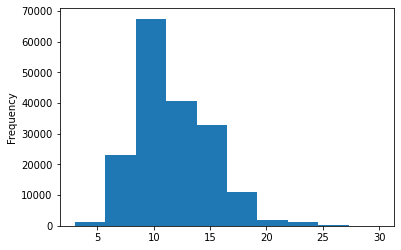

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model 

1. Create a token-level model.
2. Create a character-level model.
3. Create a model for the "line_number" feature.
4. Create a model for the "total_lines" feature.
5. Combine the outputs of 1 & 2 using `tf.keras.layer.Concatenate`.
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`.
7. Create an output layer to accept the tribird embedding and output label probabilites.
8. Combine the inputs of 1, 2, 3, 4 and outputs into a `tf.keras.Model`.


In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype="string",name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

# 3. Line number model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32, name="line_number_input")
line_number_dense_layer = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,outputs=line_number_dense_layer)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
total_number_dense_layer = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,outputs=total_number_dense_layer)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,char_model.output])
middle_dense_layer = layers.Dense(256,activation="relu")(combined_embeddings)
dropout_layer = layers.Dropout(0.5)(middle_dense_layer)

# 6. Combine postional embeddings with combined token and char embedding
tribrid_embedding = layers.Concatenate(name="char_token_postitional_embedding")([line_number_model.output,total_lines_model.output,dropout_layer])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax",name="output_layer")(tribrid_embedding)

# 8. Put together with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,total_lines_model.input,token_model.input,char_model.input],
                         outputs=output_layer,name="tribird_embedding_model")

In [ ]:
# Get the summary
model_5.summary()

Model: "tribird_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

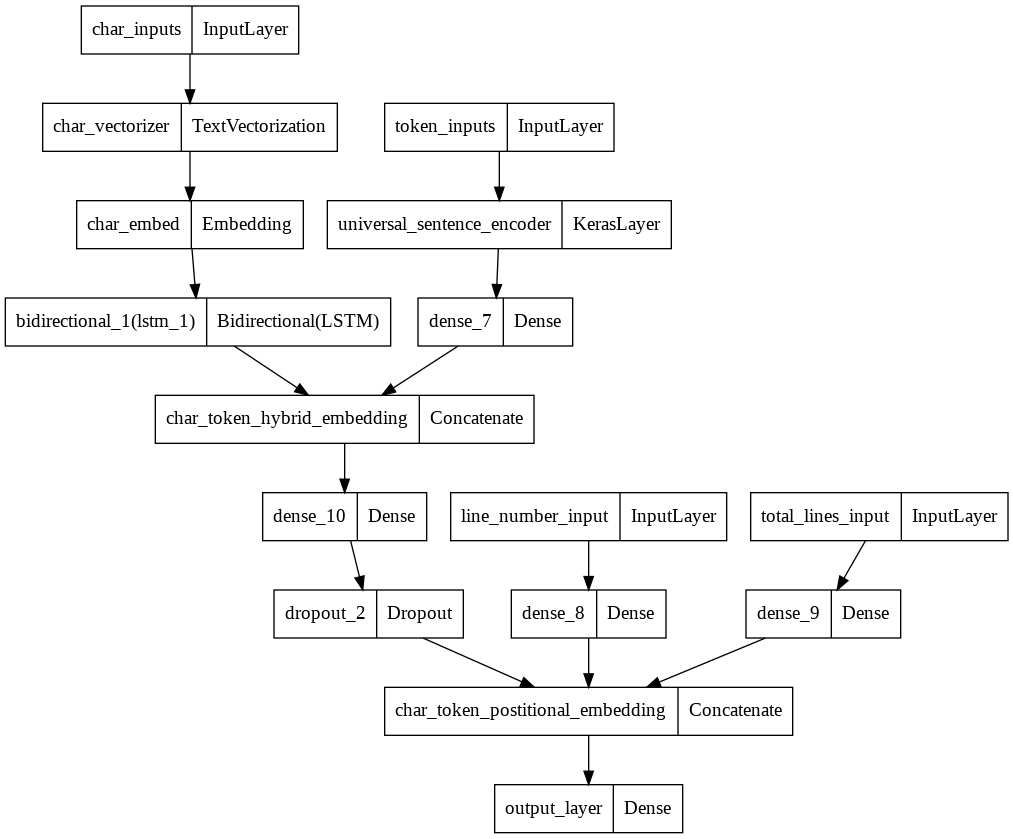

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

What is label smoothing?  

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`  

What label smoothing does is, it assigns some of the values from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`  

In [ ]:
# Compile token, char, and postional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data API

In [ ]:
# Create training dataset (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))

# Prefetch and batch the dataset
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create validation dataset (with all four kinds of input data)
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))

# Prefetch and batch the dataset
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check the input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 56ms/step - loss: 1.0896 - accuracy: 0.7298 - val_loss: 0.9822 - val_accuracy: 0.8065
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9650 - accuracy: 0.8167 - val_loss: 0.9485 - val_accuracy: 0.8298
Epoch 3/3
562/562 [==============================] - 27s 47ms/step - loss: 0.9472 - accuracy: 0.8261 - val_loss: 0.9361 - val_accuracy: 0.8348


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 32s 27ms/step


array([[0.51270026, 0.11334135, 0.00994901, 0.34755316, 0.01645626],
       [0.5333849 , 0.08906202, 0.03664433, 0.32800895, 0.01289979],
       [0.26968202, 0.10481115, 0.11038056, 0.45216542, 0.0629608 ],
       ...,
       [0.03384853, 0.11232415, 0.05016004, 0.0295484 , 0.7741189 ],
       [0.03156512, 0.32700402, 0.07564647, 0.02431575, 0.5414686 ],
       [0.23865601, 0.5237565 , 0.12987341, 0.04084633, 0.06686778]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of model_5
model_5_results = calculate_results(val_labels_encoded,model_5_preds)
model_5_results

{'accuracy': 83.49993380113861,
 'f1': 0.834015217330731,
 'precision': 0.8339472039981008,
 'recall': 0.8349993380113861}

In [ ]:
model_4_results

{'accuracy': 73.75215146299485,
 'f1': 0.7348925840679101,
 'precision': 0.73715944406448,
 'recall': 0.7375215146299484}

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({'model_0_baseline':baseline_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "model_2_pretrained_token_embedding":model_2_results,
                                  "model_3_custom_char_embedding":model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_results,
                                  "model_5_tribrid_char_token_pos_embedding":model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.703826,0.783971,0.787038,0.784657
model_2_pretrained_token_embedding,71.438501,0.714825,0.714385,0.711584
model_3_custom_char_embedding,66.033364,0.653181,0.660334,0.649786
model_4_hybrid_char_token_embedding,73.752151,0.737159,0.737522,0.734893
model_5_tribrid_char_token_pos_embedding,83.499934,0.833947,0.834999,0.834015


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"]=all_model_results["accuracy"]/100

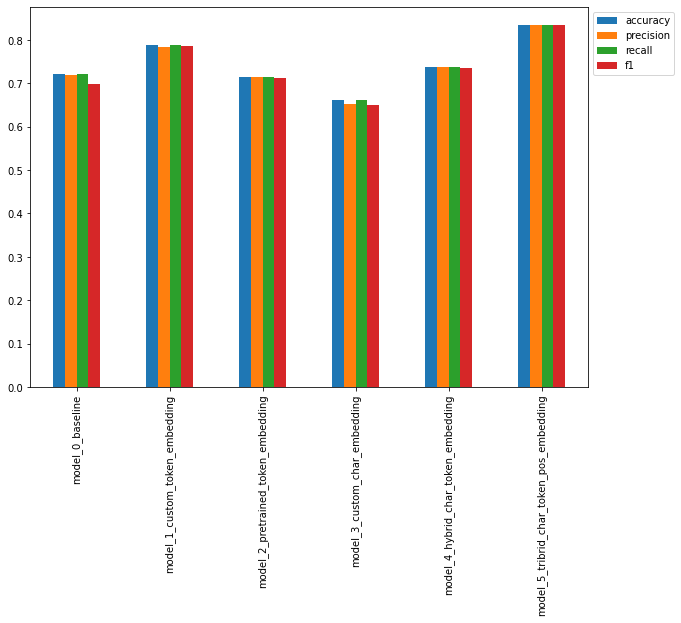

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

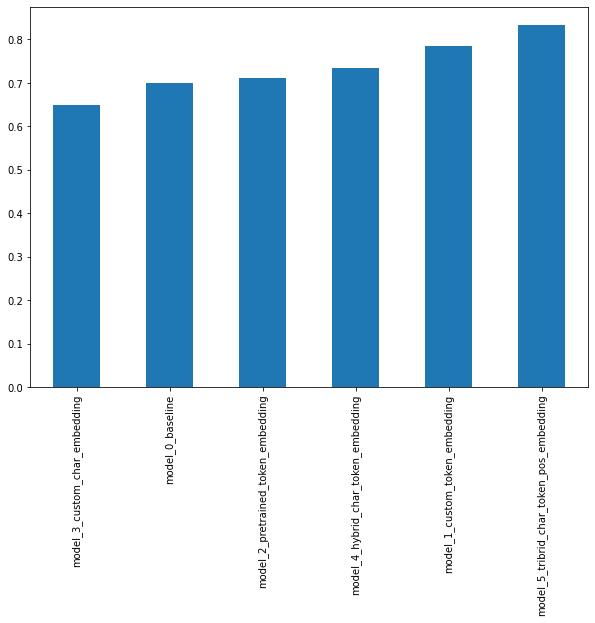

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1",ascending=True)["f1"].plot(kind="bar",figsize=(10,7));

## Save and load model

In [ ]:
# Save the best performing model
# model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions via loaded model
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs,axis=1)
loaded_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results on loaded model
loaded_model_results = calculate_results(val_labels_encoded,loaded_preds)
loaded_model_results

{'accuracy': 83.49993380113861,
 'f1': 0.834015217330731,
 'precision': 0.8339472039981008,
 'recall': 0.8349993380113861}

In [ ]:
!mkdir to_download

In [ ]:
import pickle

In [ ]:
with open('to_download/metrics_df.pkl', 'wb') as handle:
    pickle.dump(all_model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('to_download/model_0_multinomialNB.pkl', 'wb') as handle:
    pickle.dump(model_0, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# model_1.save("to_download/model_1")

In [ ]:
# model_2.save("to_download/model_2")

KeyboardInterrupt: ignored

In [ ]:
# model_3.save("to_download/model_3")

In [ ]:
# model_4.save("to_download/model_4")

In [ ]:
# !mkdir model_weights

In [ ]:
# model_5.save_weights("model_weights/best_model_weights",save_format='tf')

In [ ]:
# model_5.save("to_download/model_5")

In [ ]:
!mkdir model_weights

In [ ]:
model_json = model_5.to_json()
with open("classifier.json", "w") as json_file:
    json_file.write(model_json)
model_5.save_weights("model_weights/best_model_weight",save_format='tf')

In [ ]:
!zip -r /content/model_weights.zip /content/model_weights

  adding: content/model_weights/ (stored 0%)
  adding: content/model_weights/best_model_weight.index (deflated 78%)
  adding: content/model_weights/checkpoint (deflated 43%)
  adding: content/model_weights/best_model_weight.data-00000-of-00001 (deflated 7%)


| Experiment no.      | Description |
| :-----------: | :-----------: |
| 0      | Naive Bayes with TF-IDF encoder       |
| 1   | Conv1D with token emmbeddings        |
| 2   | Tensorflow Hub Pretrained Feature Extractor        |
| 3   | Conv1D with character embeddings        |
| 4   | Pretrained token embeddings + character embeddings        |
| 5   | Pretrained token embeddings + character embeddings + positional embeddings        |